In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

# Initialization

In this notebook, we explore how different weight initialization strategies impact the training performance of a neural network.

We'll use TensorFlow and compare:
- Zero Initialization
- Random Normal Initialization
- Xavier (Glorot) Initialization
- He Initialization

Each method will be evaluated on:

- Convergence speed
- Training/validation accuracy
- Loss behavior

We use the `make_moons` dataset, a synthetic 2D classification dataset with non-linear boundaries.
This dataset is ideal for visualizing decision boundaries and understanding how different initializations behave.

In [4]:
X, y = make_moons(n_samples=1000, noise=0.2)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
results = {}

def build_and_train_model(initializer, output_initializer = None):
    
    if output_initializer is None:
        output_initializer = initializer
    
    model = models.Sequential([
        layers.Dense(10, activation='relu', kernel_initializer=initializer, input_shape=(2,)),
        layers.Dense(5, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=output_initializer)
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))
    
    plt.style.use('seaborn-pastel')
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return {
        "model": model,
        "history": history.history
    }

## 1. Zero Intialization

All weights are initialized to 0.

This leads to the problem of **symmetry breaking**. When every neuron in a layer starts with the same weights, they all learn the same features and update identically, **behaving like a single neuron layer**.

Result: Accuracy remains low, and loss barely improves.

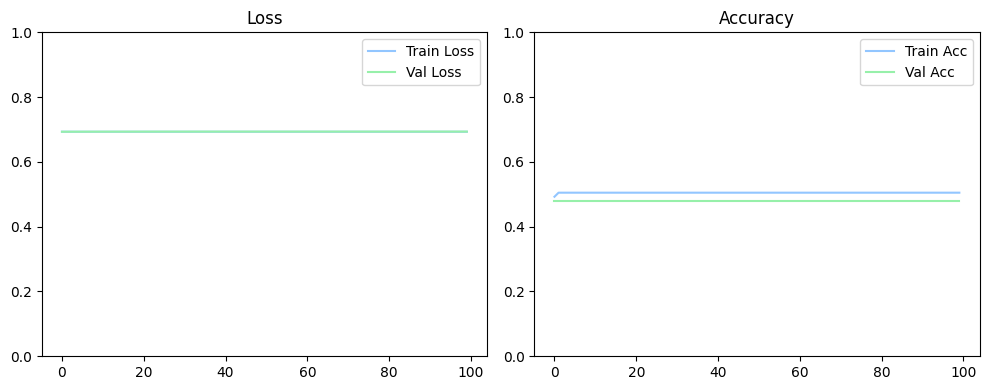

In [40]:
zero_init = initializers.Zeros()
results['Zeros'] = build_and_train_model(zero_init)

## 2. Random Normal Initialization

Weights are initialized randomly from a normal distribution:

$$
W \sim \mathcal{N}(0, \sigma^2)
$$

It breaks symmetry, each neuron starts with different weights. However, this method can suffer from **unstable gradients**, especially in deep networks.

**Exploding gradient** - if σ is too high. Gradients become very small as they are propagated backward through layers. Earlier layers learn very slowly or stop learning entirely.

**Vanishing gradient** - if σ is too low. Gradients become very large, leading to unstable updates and numerical overflow. The model's weights explode, loss becomes NaN or diverges.

Result: Some learning occurs, but training may be unstable or slow.

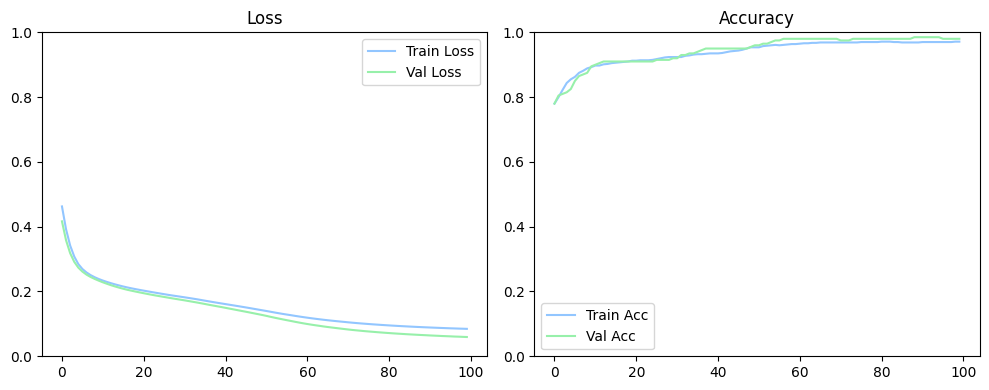

In [41]:
random_normal_init = initializers.RandomNormal(mean=0.0, stddev=1.0)
results['RandomNormal'] = build_and_train_model(random_normal_init)

## 3. Xavier Initialization

Designed to maintain the variance of activations and gradients across layers. It's ideal for layers using **tanh** or **sigmoid** activations.

$$
W \sim U\left(-\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}, \sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}\right)
$$

U - Uniform Distribution <br> 
`Dense(units=10, input_shape=(2,))` &nbsp;&nbsp; $n_\text{in} = 2,\; n_\text{out} = 10$ <br>
Balances the scale of input and output signals, helping to avoid both vanishing and exploding gradients.

Result: Stable training and good convergence for networks using smooth activation functions like sigmoid or tanh.

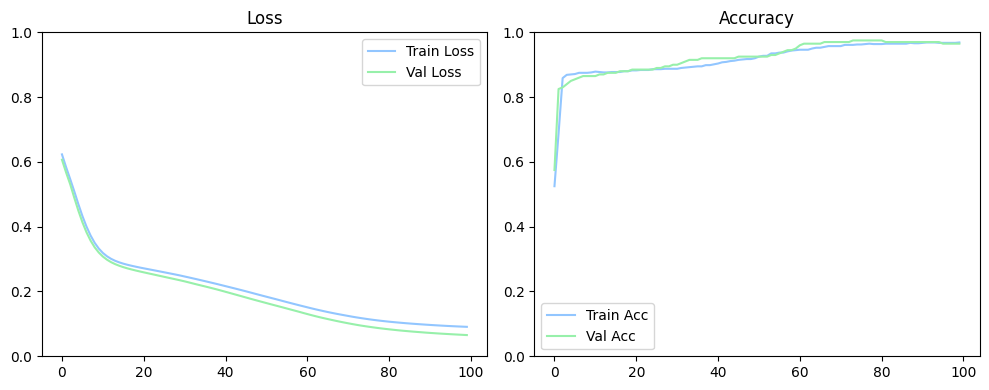

In [42]:
xavier_init = initializers.GlorotUniform()
results['GlorotUniform'] = build_and_train_model(xavier_init)

## 4. He Initialization

A variant of Xavier initialization designed specifically for **ReLU** and its variants. 

Since ReLU drops negative inputs, using Xavier can lead to vanishing gradients. He initialization compensates for this by using only positive weights.

$$
W \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n_{\text{in}}}}\right)
$$

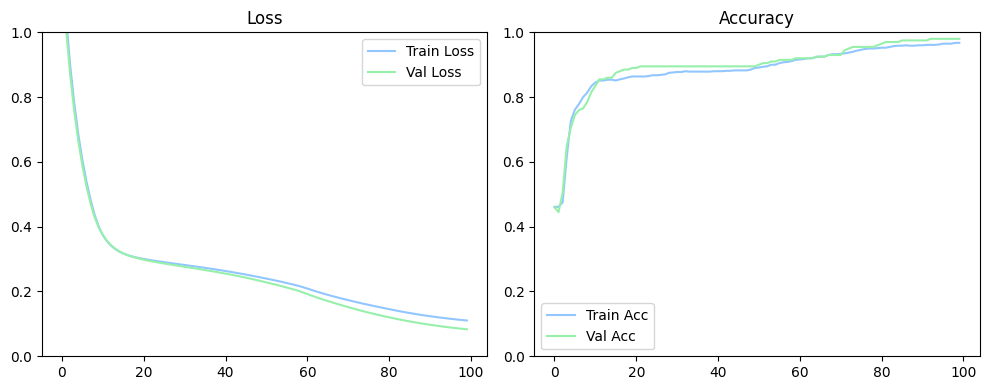

In [43]:
he_init = initializers.HeNormal()
results['HeNormal'] = build_and_train_model(he_init)

## Hybrid Initialization

- He Initialization is applied to the hidden layers, which use ReLU activations.
- Xavier (Glorot) Initialization is used for the output layer, which uses a sigmoid activation for binary classification.

Using the best initialization for each layer based on thier activation function, we see faster convergence than applying He or Xavier indiscriminately to every layer.

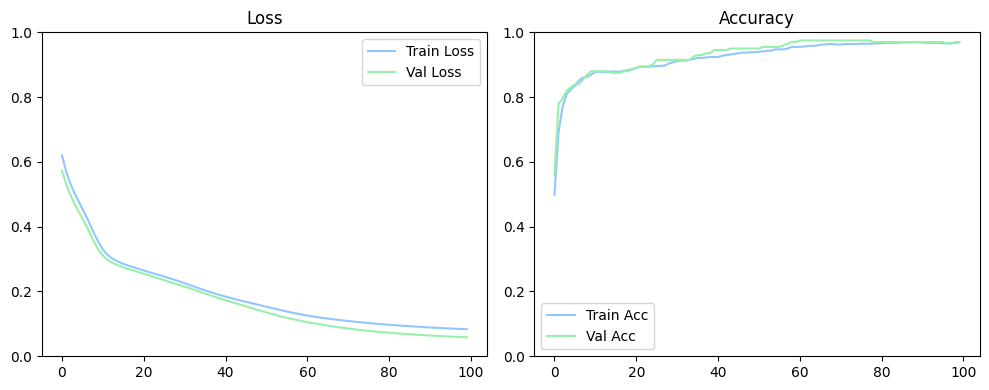

In [44]:
results['Hybrid'] = build_and_train_model(initializer=he_init, output_initializer=xavier_init)

## Conclusion

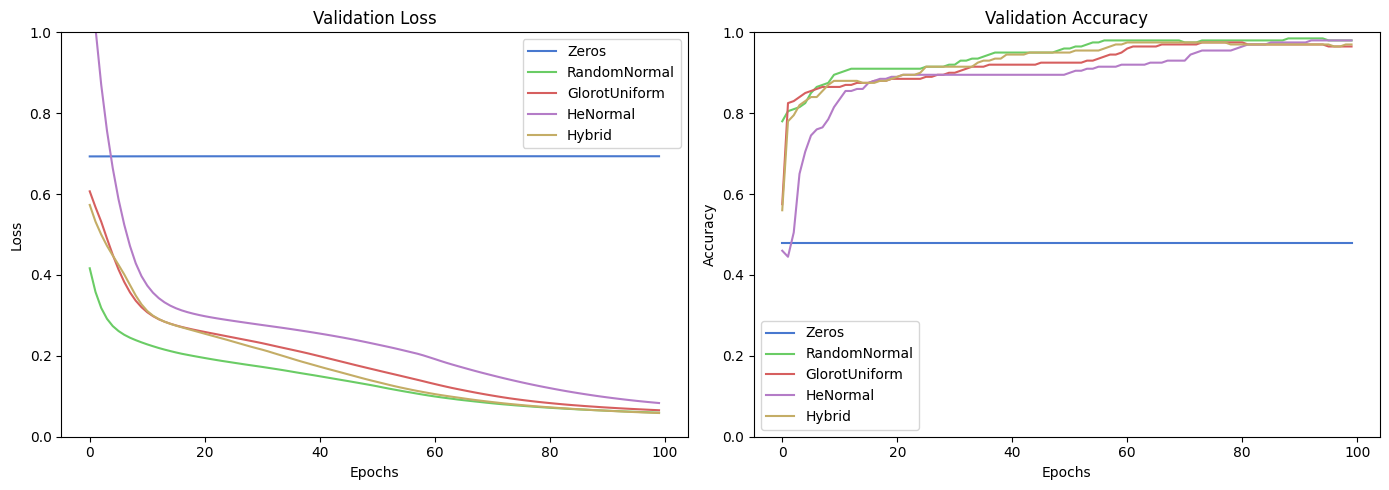

In [48]:
plt.style.use('seaborn-muted')
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for label, result in results.items():
    plt.plot(result['history']['val_loss'], label=label)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
for label, result in results.items():
    plt.plot(result['history']['val_accuracy'], label=label)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()
